# Рекомендация тарифов

Описание проекта
Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на тарифы Смарт и Ультра. Нужно построить модель для задачи классификации, которая выберет подходящий тариф.
данные предобратоны ранее

Описание данных
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

    сalls — количество звонков,
    minutes — суммарная длительность звонков в минутах,
    messages — количество sms-сообщений,
    mb_used — израсходованный интернет-трафик в Мб,
    is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).
    
Задача:
Построить модель с максимально большим значением *accuracy*, не меньше 75%.
будем решать задачу бинарной классификации и обучения модели с учителем

План работы:

    Откроем и изучим файл
    Разобьём данные на выборки
    Проведем исследоввание моделей
    Проверим лучшую модель на тестовых данных
    Проверим модель на адекватность
    Подведём общий итог о проделанной работе

## Откроем и изучим файл

In [1]:
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier 
from sklearn.metrics import accuracy_score, f1_score, recall_score
#from joblib import dump, load # закомментировать

In [2]:
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 300)

In [3]:
try:
    user_behavior = pd.read_csv('/home/oslik/Yandex_curs_DS/Project_s2_1/datasets/users_behavior.csv')
except:
    user_behavior = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

In [4]:
user_behavior.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [5]:
user_behavior.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [6]:
user_behavior.dtypes

calls       float64
minutes     float64
messages    float64
mb_used     float64
is_ultra      int64
dtype: object

In [7]:
user_behavior.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [8]:
user_behavior.duplicated().sum()

0

столбцы 'calls', 'messages' по смыслу и содержанию должны иметь целочисленнный тип данных, а не c плавающей запятой. исправим это.

In [9]:
user_behavior[['calls', 'messages']] = user_behavior[['calls', 'messages']].astype(int)

### Краткий вывод
    были изучены предоставленные данные, на предмет пропусков, дубликатов, и их распределение. 
    в ходе изучения даннных было обнаружено и испправлено несоответствие типов в столбцах 'calls' и 'messages'


## Разделим данные на выборки

Тестовая выборка не предоставлена. Значит, данные нужно разбить на три части: обучающую, валидационную и тестовую. Размеры тестового и валидационного наборов сделаем равными и распределим их в соотношении 3:1:1 (данные для обучения/проверрочная выборка/тестовая выборка). 
<p>сделаем это в 2 этапа
<ol>
<li>отделим 60% от основной выборки для обучения моделей и 40% отведем для тестовой и валидационнной выброк </li>
<li>разделим данные для тестовой и валидационной выборок в соотношении 50/50</li>
</ol>
для равномерного распределения данных по выборкам используем параметр stratify, которому передадим поле для отслеживания разделения

In [10]:
learn_data, valid_data, learn_target, valid_target = \
train_test_split(
    user_behavior.drop('is_ultra', axis=1),
    user_behavior.is_ultra,
    test_size=0.4,
    random_state=12345,
    stratify=user_behavior.is_ultra,
)

test_data, valid_data, test_target, valid_target = \
train_test_split(
    valid_data,
    valid_target,
    test_size=0.5,
    random_state=12345,
    stratify=valid_target
)

проверим соотношение

In [11]:
dick = {'learn_data': learn_data,
          'test_data': test_data,
          'valid_data': valid_data}
for i in dick:
    print(f'доля {i} = {dick[i].shape[0]/user_behavior.shape[0]:.4%}')

доля learn_data = 59.9876%
доля test_data = 20.0062%
доля valid_data = 20.0062%


### Краткий вывод
    полученные данные были разделены на обучающую, тестовую, валидационную выборки в отношении 3:1:1

## Исследоввание моделей

для автоматизации и визуализации результатов применения моделей обучения создадим 2 функции.
<ol>
<li>build_graph - будет отвечать за визуализацию результатов </li>
<li>my_model - за применение параметров к модели</li>
</ol>
<b> рассматривать модели будем в следующем порядке:
<ol>
<li>DecisionTreeClassifier (дерево) </li>
<li>RandomForestClassifier (случайный лес)</li>
<li>LogisticRegression (логистическая регрессия)</li>
</ol>
для дальнейшего использования параметров лучших моделей, создадим таблицу для их хранения

In [12]:
data = pd.DataFrame({'name': [], 'best_result': [],
                     'F1_score': [], 'model': [], #'model_dump':[]
                    })


In [13]:
def build_graph(res_tree:dict, best_depth:list, titles:str)->plt:

    fig, ax = plt.subplots(ncols=1, figsize=(15,5))
    sns.lineplot(ax=ax, 
                 y=res_tree['valid'].values(),
                 x=res_tree['valid'].keys(),
                 color='#00BFFF',
                 legend=True,
                 label='проверочные данные',
                )
    sns.lineplot(ax=ax,
                 y=res_tree['learn'].values(),
                 x=res_tree['learn'].keys(),
                 color='#800000',
                 legend=True,
                 label='данные для обучения',
                )
    plt.title(titles)
    sns.scatterplot(
        x=[best_depth[0],],
        y=[best_depth[1],],
        color='#191970',
        s=70,
    )
    plt.ylabel('точность модели')
    plt.xlabel('настройки модели')
    
    plt.annotate(
        f'лучшая точность {best_depth[1]:.5%}',
        xy=(best_depth[0],
            best_depth[1]),
        xytext=(10, 0),
        textcoords='offset points',
        fontweight='bold',
        rotation=0,
    )
    plt.legend ()
    return plt

In [14]:
def my_model(data, models, models_settings, stop=50, start=1):
    
    res = {'valid': dict(), 'learn': dict()}
    best_model = None
    best_result = 0
    for models_setting in models_settings:
        model = models(**models_setting)
        model.fit(learn_data, learn_target)

        dict_item = models_setting[list(models_setting.keys())[0]]

        tmp_valid = accuracy_score(
            valid_target, 
            model.predict(valid_data))

        tmp_learn = accuracy_score(
            learn_target,
            model.predict(learn_data))

        if tmp_valid > best_result:
            best_model = model
            best_result = tmp_valid
            best_depth = dict_item
        res['valid'][dict_item] = tmp_valid
        res['learn'][dict_item] = tmp_learn
        
    data = data.append({
        'name': models.__name__,
        'best_result': best_result,
        'F1_score': f1_score(
            valid_target,
            model.predict(valid_data),
            average='micro',
        ),
        'model': f'{best_model=}', 
        #'model_dump': dump(best_model, models.__name__+'.joblib') для сохранения в файл
    },
        ignore_index=True)
    #print(best_result)
    try:
        models_settings[0]['penalty']
        titles = f'{models.__name__} (penalty: {models_settings[0]["penalty"]}, solver: {models_settings[0]["solver"]})'
    except: titles = f'{models.__name__}'
    build_graph(res, [best_depth, best_result], titles).show()
    print("Accuracy лучшей модели:", best_result)
    return data

### Исследуем данные с помошью дерева решений

при исследовании модели будем использовать максимальную глубину дерева от 1 до 40 и random_state (для воспроизводения случайных значений) равным 12345

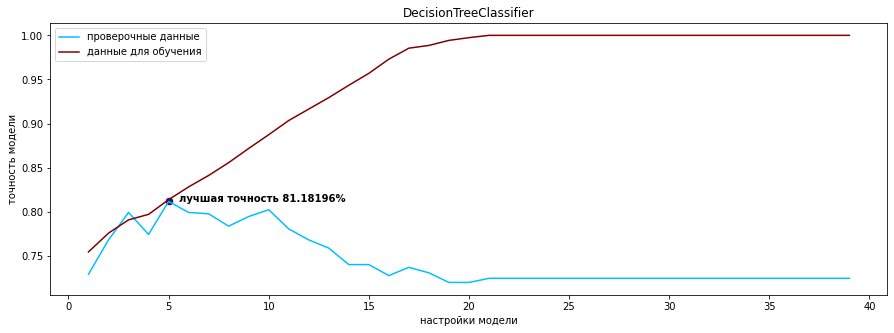

Accuracy лучшей модели: 0.8118195956454122


In [15]:
data = my_model(
    data=data,
    models=DecisionTreeClassifier,
    models_settings=[
        {
            'max_depth': i,
            'random_state':12345,
        }
        for i in range(1, 40)],
)

### Исследуем данные с помошью случайного леса решений

Число деревьев в лесу решений установим в диапазоне от 1 до 50 и random_state (для воспроизводения случайных значений) равным 12345

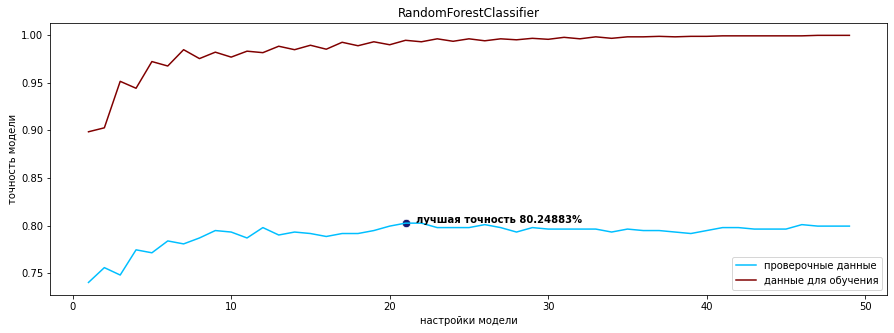

Accuracy лучшей модели: 0.80248833592535


In [16]:
data = my_model(
    data=data,
    models=RandomForestClassifier,
    models_settings=[
        {
            'n_estimators': i,
            'random_state':12345,
        }
        for i in range(1, 50)],
)

### Исследуем данные с помошью логистической регрессии


будем использовать штрафы 'l1' и 'l2'
<p>в качестве параметров в solver будем передовать 'lbfgs', 'liblinear'
<p>Максимальное количество итераций, необходимых для сходимости решателей будет в диапазоне (10, 100)

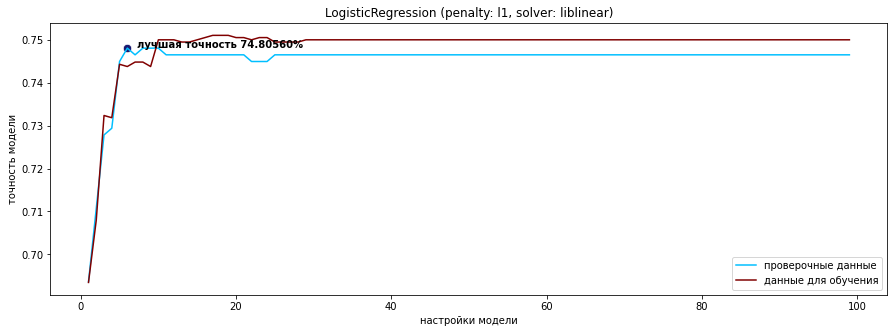

Accuracy лучшей модели: 0.7480559875583204


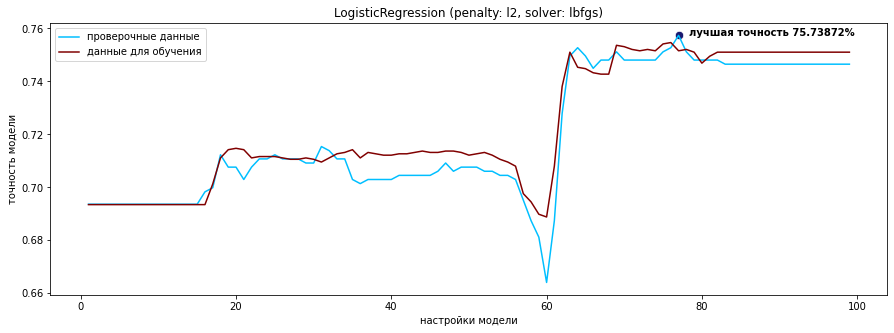

Accuracy лучшей модели: 0.7573872472783826


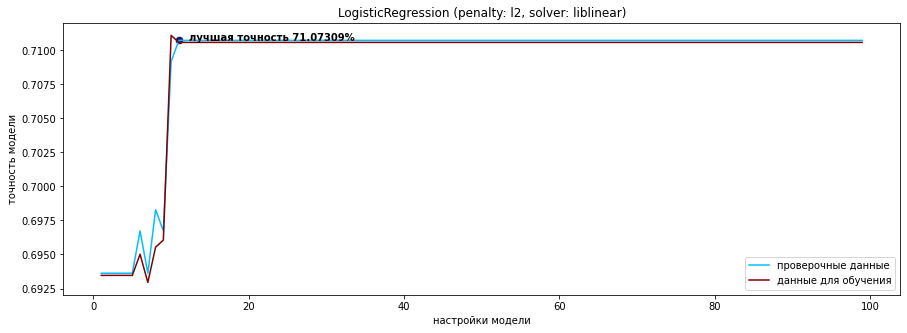

Accuracy лучшей модели: 0.7107309486780715


In [17]:
dict_penalty = {'l1': ['liblinear'],
 'l2': ['lbfgs', 'liblinear']}
for penalty in dict_penalty:
    for solver in dict_penalty[penalty]:
        data = my_model(
            data=data,
            models=LogisticRegression,
            models_settings=[
                {
                    'max_iter': i,
                    'penalty': penalty,
                    'solver': solver,
                    'random_state': 12345,
                }
                for i in range(1, 100)],
        )

как видно из графиков лучшая доля правильных ответов была получена при использовании параметров penalty = 'l2' и solver ='lbfgs'

выберем лучшую модель по показателю f1_score из всех моделей

In [18]:
data = data.sort_values(by=['F1_score'], ascending=False)[~data.drop(columns=['model']).duplicated(keep='last')]
data.drop('model', axis=1)

,name,best_result,F1_score
1,RandomForestClassifier,0.802488,0.799378
2,LogisticRegression,0.748056,0.746501
3,LogisticRegression,0.757387,0.746501
0,DecisionTreeClassifier,0.811820,0.724728
4,LogisticRegression,0.710731,0.710731


### Краткий вывод

были рассмотрены 3 модели:
<ol>
    <li> RandomForestClassifier
    <li> LogisticRegression
    <li> DecisionTreeClassifier 	
</ol>
<p> лучшей из них по соотношению среднеквадратичному отклонению является первая модель, с результатом, на проверочной выборке в 80.2% и f1_score = 0.799378

## Проверим лучшую модель на тестовой выборке

посмотрим, что у нас получилось в таблице с моделями

In [19]:
data

,name,best_result,F1_score,model
1,RandomForestClassifier,0.802488,0.799378,"best_model=RandomForestClassifier(n_estimators=21, random_state=12345)"
2,LogisticRegression,0.748056,0.746501,"best_model=LogisticRegression(max_iter=6, penalty='l1', random_state=12345,\n solver='liblinear')"
3,LogisticRegression,0.757387,0.746501,"best_model=LogisticRegression(max_iter=77, random_state=12345)"
0,DecisionTreeClassifier,0.811820,0.724728,"best_model=DecisionTreeClassifier(max_depth=5, random_state=12345)"
4,LogisticRegression,0.710731,0.710731,"best_model=LogisticRegression(max_iter=11, random_state=12345, solver='liblinear')"


применим тестовые данные к моделям

In [20]:
for numb, name in enumerate(data.name):
    exec(data.model.iloc[numb])
    best_model.fit(learn_data, learn_target)
    predict = best_model.predict(test_data)
    print(name, best_model.get_params)
    print('accuracy_score: ', f'{accuracy_score(test_target, predict) : .2%}')
    print('f1_score: ', f'{f1_score(test_target, predict, average="micro"): .6f}')
    print('\n', '*' * 50, '\n')

RandomForestClassifier <bound method BaseEstimator.get_params of RandomForestClassifier(n_estimators=21, random_state=12345)>
accuracy_score:   79.94%
f1_score:   0.799378

 ************************************************** 

LogisticRegression <bound method BaseEstimator.get_params of LogisticRegression(max_iter=6, penalty='l1', random_state=12345,
                   solver='liblinear')>
accuracy_score:   72.94%
f1_score:   0.729393

 ************************************************** 

LogisticRegression <bound method BaseEstimator.get_params of LogisticRegression(max_iter=77, random_state=12345)>
accuracy_score:   74.03%
f1_score:   0.740280

 ************************************************** 

DecisionTreeClassifier <bound method BaseEstimator.get_params of DecisionTreeClassifier(max_depth=5, random_state=12345)>
accuracy_score:   78.54%
f1_score:   0.785381

 ************************************************** 

LogisticRegression <bound method BaseEstimator.get_params of Logisti

### Краткий выввод

при проверке моделей на тестовой выборке получили следующие результаты:
<p>лучшая модель, показавшая большую оценку F1 и лучшую точность, при проверке на тестовых данных показала схожие результаты.
<lo>
    <li> доля правильных ответов в районе:  <b><i>79,94%</b></i>
    <li> оценка F1: <b><i>0.799378</b></i>
</lo>

## (бонус) Проверьте модели на адекватность

для проверки модели на адекватность посмотрим что даст использование модели DummyClassifier.
DummyClassifier в качестве предсказания возвращает самое часто встречающееся значение.  
по факту, если наша модель возвращает значение хуже, то она не работает от слова совсем..

In [21]:
dummy = DummyClassifier(strategy="most_frequent")
X = user_behavior.drop('is_ultra', axis=1)
y = user_behavior.is_ultra
dummy.fit(X, y)
print('accuracy_score: ', f'{dummy.score(X, y) : .2%}')
print('f1_score: ', f'{f1_score(y, dummy.predict(X), average="micro"): .6f}')

accuracy_score:   69.35%
f1_score:   0.693528


учитывая, что доля правильных ответов и оценка F1 нашей модели выше доли правильных ответов и оценки F1 DummyClassifier, то выбранную модель можно считать рабочей

## Вывод:

В ходе реализации проекта были проведены следующие работы:
<ol>
<li>    Открыт и изучен файл, 
<li>    Разделены данные на выборки
<li>    Проведено исследоввание моделей <b>RandomForestClassifier, LogisticRegression, DecisionTreeClassifier </b> в ходе чего лучшей моделью из расматриваемых оказалась RandomForestClassifier запущенная с параметрами (n_estimators=21, random_state=12345)
    <p>
    <p>доля правильных ответов модели: 80,25% 
    <p> оценка F1: 0.799378
<p>
<li>    Лучшую модель была проверена на тестовых данных в ходе чего были получены результаты схожие с данными полученными при проведении иследований моделей
    <p>
    <p>доля правильных ответов в районе: 79,94%
    <p>оценка F1: 0.799378 
<p>
<li>    Модель была проверена на адекватность с помошью метода DummyClassifier
<li>    Подводя общий итог проделанной работе можно сказать, что модель RandomForestClassifier является наилучшей из рассмотренных
</ol>